# **Tutorial for cell-cell communication prediction for single-ST data with DeepTalk**

The notebook introduces to predicting cell-cell comunication using the DeepTalk method.

The notebook uses data from mouse brain cortex.).

## **Installation**
Make sure ```DeepTalk_ST``` is installed via ```pip install DeepTalk_ST```.

The Python environment needs to install the packages listed in ```environment.yml```.

In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## **Create a work folder and Download the data**

The MERFISH_genes.csv, st_flie.txt, st_location.txt, single_cell_process.R, geneinfo.rda,pathways.rda, lrpairs_new.csv, df_pathways.csv can be downloaded from https://github.com/JiangBioLab/DeepTalk/tree/main/test.

In [2]:
Test_dir = './test/single-cell/'
isExists = os.path.exists(Test_dir)
if isExists:
    pass
else:
    os.makedirs(Test_dir)

In [3]:
'''
# Skip this cells if data are already downloaded
!wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.rar -O ./Test1/single-cell/visp_sn_tpm_small_0430.rar
!tar -xf visp_sn_tpm_small_0430.rar -C Test_dir
'''

'\n# Skip this cells if data are already downloaded\n!wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.rar -O ./Test1/single-cell/visp_sn_tpm_small_0430.rar\n!tar -xf visp_sn_tpm_small_0430.rar -C Test_dir\n'

## **Load spatial data**
Spatial data need to be organized as a voxel-by-gene matrix. Here, MERFISH data contains 2,399 spatial voxels, in each of which there are 268 genes measured.

In [4]:
random.seed(1000)
ad_st = sc.read_csv(Test_dir + "/st_flie.txt", delimiter='\t', first_column_names=True)
ad_st

AnnData object with n_obs × n_vars = 2399 × 268

In [5]:
ad_st_raw = copy.deepcopy(ad_st)
#ad_st_raw = ad_st
sc.pp.normalize_total(ad_st)
#ad_st_raw1 = copy.deepcopy(ad_st)
#sc.pp.normalize_per_cell(ad_st, counts_per_cell_after=1e4)
sc.pp.log1p(ad_st)

In [6]:
st_spatial = np.loadtxt(Test_dir + "/st_location.txt",dtype=str, delimiter=' ')
st_spatial = st_spatial.astype(np.float64)

In [7]:
ad_st.obs['x'] = st_spatial[:,0]
ad_st.obs['y'] = st_spatial[:,1]
ad_st.obsm["spatial"]=st_spatial
ad_st_raw.obsm["spatial"]=st_spatial

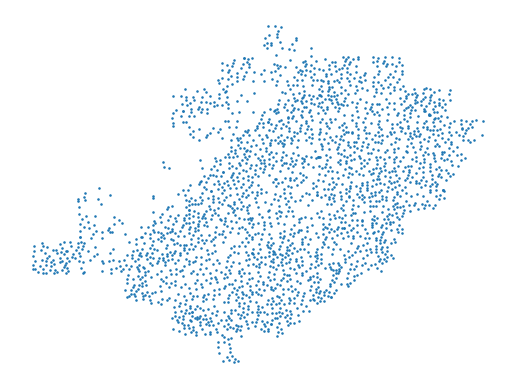

In [8]:
xs = ad_st.obs.x.values
ys = ad_st.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);
plt.gca().invert_yaxis()

## **Single cell data**
By single cell data, we generally mean either scRNAseq or snRNAseq.
They are 11,759 SMART-Seq2 snRNA-seq data from the VISp region.

In [9]:
path = os.path.join(Test_dir + "/visp_sn_tpm_small_0430.h5ad")
ad_sc = sc.read_h5ad(path)

In [10]:
ad_sc_raw0 = copy.deepcopy(ad_sc)
sc.pp.normalize_total(ad_sc)
#sc.pp.normalize_per_cell(ad_sc, counts_per_cell_after=1e4)
ad_sc_raw1 = copy.deepcopy(ad_sc)
sc.pp.log1p(ad_sc)
ad_sc_raw = copy.deepcopy(ad_sc)
sc.pp.highly_variable_genes(ad_sc, min_mean=0.0125, max_mean=4, min_disp=0.25)
sc.pp.scale(ad_sc, max_value=10)
ad_sc_raw2 = copy.deepcopy(ad_sc)
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.umap(ad_sc)
ad_sc

AnnData object with n_obs × n_vars = 11759 × 40056
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [11]:
ad_sc_raw.obsm['X_umap']=ad_sc.obsm['X_umap']

## **Prepare to integration**

In [12]:
df_genes = pd.read_csv(Test_dir + '/MERFISH_genes.csv',header=None)
markers = np.reshape(df_genes.values[:,-1], (-1, ))
markers = list(markers)
len(markers)

254

In [13]:
dt.pp_adatas(ad_sc_raw, ad_st, genes=markers)

INFO:root:253 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:257 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## **Integration sc/snRNA-seq and ST data**

In [14]:
ad_map = dt.map_cells_to_space(
    adata_sc=ad_sc_raw,
    adata_sp=ad_st,
    learning_rate=0.0001,
    num_epochs=3000,
    device='cuda:0',
)

Start training
Epoch 100, Loss: -0.530,Score0: 0.530,Time: 0.118
Epoch 200, Loss: -0.564,Score0: 0.564,Time: 0.119
Epoch 300, Loss: -0.591,Score0: 0.591,Time: 0.131
Epoch 400, Loss: -0.609,Score0: 0.609,Time: 0.113
Epoch 500, Loss: -0.623,Score0: 0.623,Time: 0.109
Epoch 600, Loss: -0.634,Score0: 0.634,Time: 0.115
Epoch 700, Loss: -0.643,Score0: 0.643,Time: 0.118
Epoch 800, Loss: -0.650,Score0: 0.650,Time: 0.131
Epoch 900, Loss: -0.657,Score0: 0.657,Time: 0.120
Epoch 1000, Loss: -0.662,Score0: 0.662,Time: 0.118
Epoch 1100, Loss: -0.668,Score0: 0.668,Time: 0.117
Epoch 1200, Loss: -0.672,Score0: 0.672,Time: 0.120
Epoch 1300, Loss: -0.677,Score0: 0.677,Time: 0.122
Epoch 1400, Loss: -0.681,Score0: 0.681,Time: 0.117
Epoch 1500, Loss: -0.685,Score0: 0.685,Time: 0.118
Epoch 1600, Loss: -0.689,Score0: 0.689,Time: 0.120
Epoch 1700, Loss: -0.692,Score0: 0.692,Time: 0.126
Epoch 1800, Loss: -0.696,Score0: 0.696,Time: 0.120
Epoch 1900, Loss: -0.699,Score0: 0.699,Time: 0.120
Epoch 2000, Loss: -0.701,

In [15]:
import torch
torch.cuda.empty_cache()

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

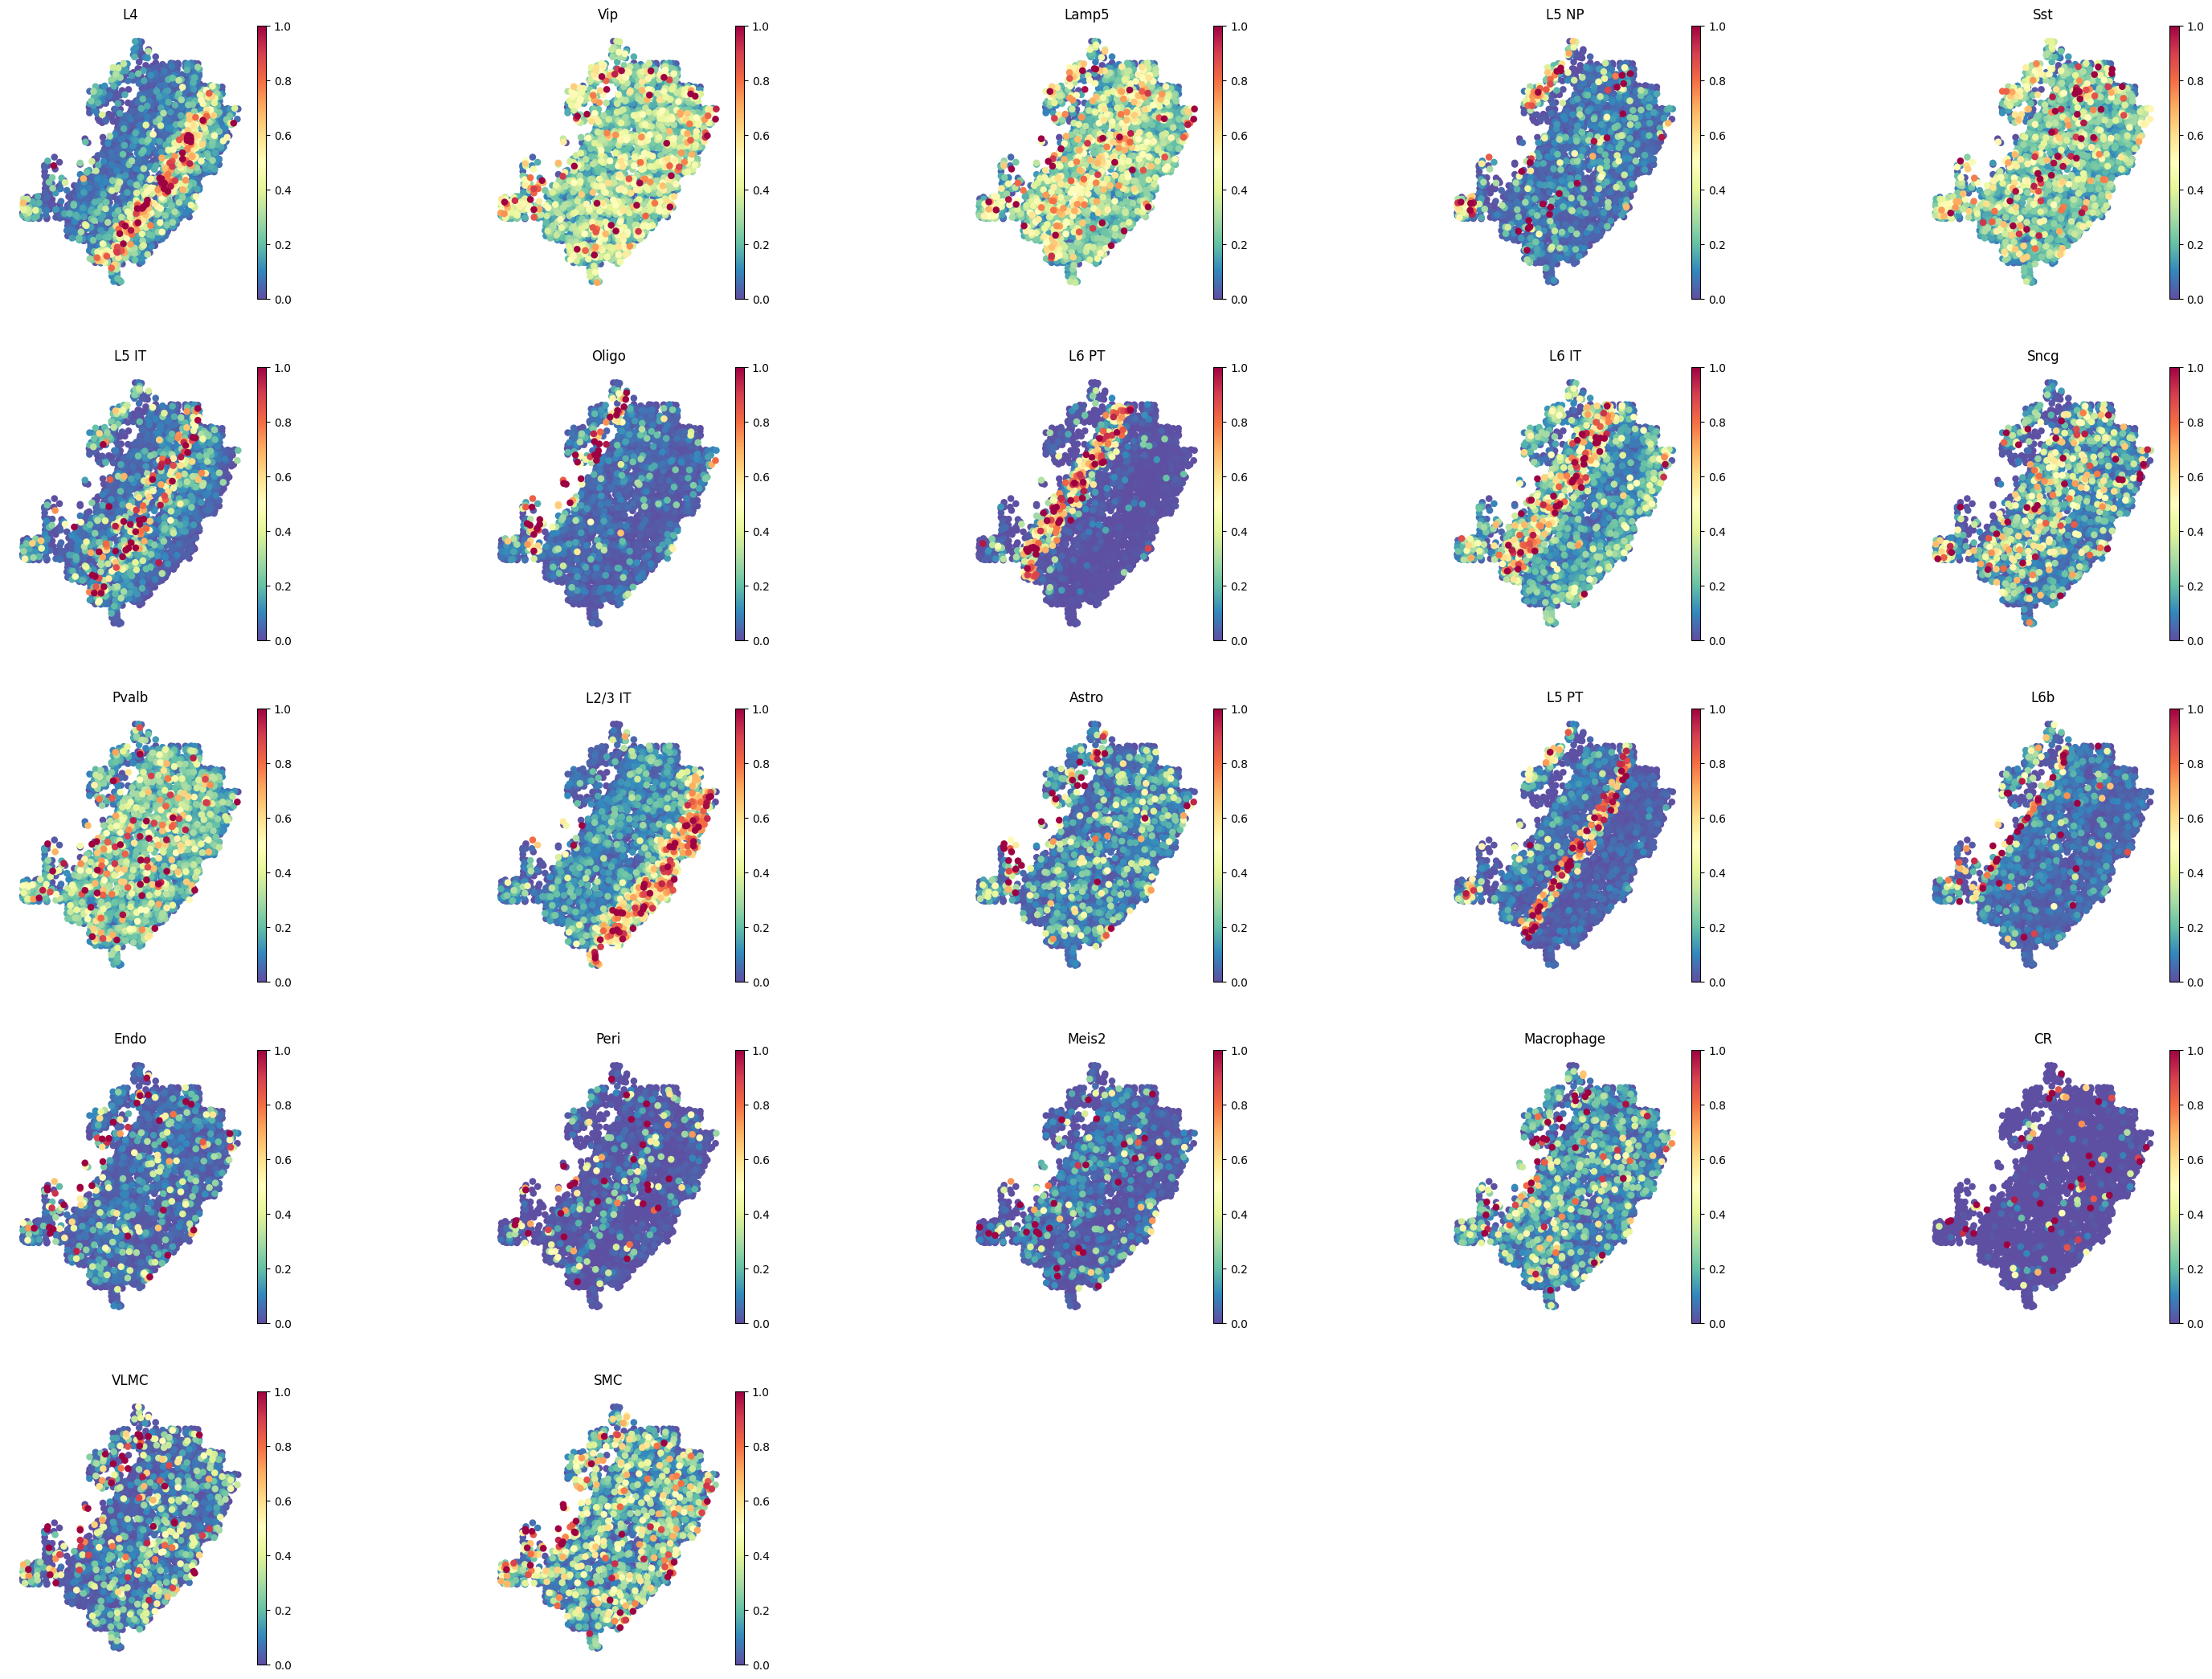

In [16]:
dt.project_cell_annotations(ad_map, ad_st, annotation="subclass")
annotation_list = list(pd.unique(ad_sc_raw.obs['subclass']))
dt.plot_cell_annotation_sc1(ad_st, annotation_list,spot_size=65, ncols=5,cmap='Spectral_r', scale_factor=0.1,perc=0.01)

In [17]:
ad_st.obs.to_csv(Test_dir + '/st_obs.csv')

## **Prepare to inference of cell-cell communication**

In [18]:
gene_all_mouse, gene_all_human = dt.gene_select(lrpairs = Test_dir + '/lrpairs_new.csv',TF = Test_dir + '/df_pathways.csv')

In [19]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=ad_sc_raw)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 40056
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'sparsity', 'is_training'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [20]:
sc.pp.filter_cells(ad_ge, min_genes=200)
sc.pp.filter_genes(ad_ge, min_cells=3)
sc.pp.filter_genes_dispersion(ad_ge, flavor='cell_ranger', log=False)
ad_ge = ad_ge[:, ad_ge.X.mean(axis=0) >= 0.1]
ad_ge

View of AnnData object with n_obs × n_vars = 2399 × 2057
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'sparsity', 'is_training', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'training_genes', 'overlap_genes'

## **Prepare to inference of cell-cell communication**

In [21]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [f'C{i}' for i in range(1, ad_ge.X.shape[0]+1)]
df = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
df = df[df.index.isin(gene_all_mouse)]
df.to_csv(Test_dir + '/ad_st_new.csv',float_format='%.2f')
df

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C2390,C2391,C2392,C2393,C2394,C2395,C2396,C2397,C2398,C2399
Abhd6,0.136808,0.222054,0.172783,0.187538,0.289073,0.254075,0.224584,0.150379,0.247721,0.255100,...,0.380624,0.495894,0.315121,0.466425,0.392568,0.261048,0.487327,0.282349,0.701594,0.472965
Acaa1a,0.114608,0.173894,0.189614,0.111635,0.216319,0.227494,0.157123,0.114499,0.196834,0.395177,...,0.197454,0.381570,0.176879,0.327026,0.216388,0.147704,0.353268,0.167925,0.521382,0.293568
Acat1,0.209733,0.350318,0.256490,0.263003,0.412603,0.409509,0.291700,0.262893,0.352057,0.643319,...,0.389581,0.710654,0.338944,0.466684,0.404797,0.287170,0.591610,0.370654,0.873205,0.415486
Acot13,0.931381,1.351919,0.997444,1.000815,1.561515,1.608094,1.168035,0.992472,1.438769,2.290865,...,1.529908,2.416951,1.396608,1.899776,1.687771,1.184931,1.701864,1.468114,4.022119,1.804453
Acot7,0.905572,1.254040,0.891955,1.018183,1.823778,1.565295,1.040869,0.995359,1.422320,2.114555,...,1.532161,2.038274,1.394886,1.773746,1.620756,1.130259,1.923992,1.530110,3.282120,1.945166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhae,1.218126,1.897679,1.303063,1.395942,2.492169,2.184056,1.587222,1.509977,1.993377,2.962948,...,2.507578,3.854653,2.099541,2.543332,2.611314,1.852656,3.381845,2.251307,4.037035,2.735557
Ywhag,0.212790,0.353386,0.257346,0.253170,0.484973,0.434225,0.276264,0.290180,0.375480,0.725032,...,0.405408,0.607938,0.361298,0.415955,0.432188,0.329400,0.640454,0.412876,0.759668,0.478048
Ywhah,1.450964,2.957338,1.616096,2.032455,3.682507,3.417909,2.198128,2.178843,2.890920,3.927942,...,3.892768,4.089485,3.014084,3.513159,3.959332,3.015435,4.396176,3.297988,4.496940,3.230983
Ywhaq,0.500096,0.768973,0.571882,0.547651,1.059576,0.906824,0.608872,0.575413,0.812271,1.369843,...,1.010784,1.400711,0.800007,1.109306,1.018366,0.737410,1.406633,0.851882,1.959263,1.027946


## **Generate training dataset and prediction dataset.**
Using the example of intercellular communication mediated by ```Sst-Sstr2``` and ```Apoe-Grm5```, train using ```Sst-Sstr2``` and predict intercellular communication mediated by ```Apoe-Grm5```.

In [22]:
dt.File_Train(data_name = Test_dir + '/ad_st_new.csv', LR_train = 'Sst_Sstr2',
	outdir =  Test_dir)

staring


Generate predict file

In [23]:
dt.CCC_LR_pre(data_name = Test_dir + '/ad_st_new.csv',ligand = 'Apoe', receptor = 'Grm5',
           cell_pair = Test_dir + '/cell_pair_all.csv', outdir = Test_dir)

staring


**Generate training data and prediction data.**

In [24]:
dt.data_for_train(data_dir = Test_dir +'/data/', data_name = Test_dir + '/ad_st_new.csv', 
	LR_train = 'Sst_Sstr2')

In [25]:
dt.data_for_test(data_dir = Test_dir +'/data/', data_name = Test_dir + '/ad_st_new.csv', 
	LR_test = 'Apoe_Grm5')

In [26]:
import torch
torch.cuda.empty_cache()

## **Prediction of spatial CCC at the single-cell resolution.**
Train the data using subgraph-based GAT and generate a prediction model.

The training process may take some time.

The trained model can be used to predict intercellular communication mediated by other L-R interactions.

In [27]:
dt.Train(data_name = 'Sst_Sstr2',data_path = Test_dir + '/data/',
    outdir = Test_dir + '/data/Sst_Sstr2/output',
    pretrained_embeddings = Test_dir + '/data/Sst_Sstr2/data_pca.emd',
    n_epochs = 50,ft_n_epochs=10)


 Loading graph...
DataSet Stats :
Number of Nodes 2398
Number of Edges 96583
Number of Node types 1
Number of relations 1
Graph with 2398 nodes and 96583 edges
2398 2
check torch.Size([2398, 128]) 2397
node2vec tensor torch.Size([2398, 128])
No. of nodes with pretrained embedding:  2398
No. edges in test data:  38599
***************PRETRAINING***************

 Generating subgraphs for pre-training ...

 generate walks ...
no. of walks 19184

 split data to train/validate/test and save the files ...
train ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_train.txt
validate ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_validate.txt
test ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_test.txt
15347 1919 1918
number of batches for pre-training:  {'train': 15, 'validate': 2, 'test': 2}

 Run model for pre-training ...
2398

 processing walks in minibaches before running model:
train
validate
test

 Begin Training

Epoch: 0
MinLoss: 1000000.0, CurLoss: 7.90

**Predicting cell-cell communication mediated by ```Apoe-Grm5```.**

In [28]:
dt.run_predict(data_name='Apoe_Grm5',data_path = Test_dir +'/data/',
    outdir = Test_dir +'/data/Apoe_Grm5/output',
    pretrained_embeddings = Test_dir +'/data/Apoe_Grm5/data_pca_test.emd',model_path = Test_dir+'/data/Sst_Sstr2/output/finetune/results')

DataSet Stats :
Number of Nodes 2318
Number of Edges 90959
Number of Node types 1
Number of relations 1
check torch.Size([2318, 128]) 2246
node2vec tensor torch.Size([2318, 128])
4 4 Linear(in_features=512, out_features=512, bias=True)
Begin Predicting
Done


## **Visualize of the spatial CCC**


In [29]:
mapping_colors = {
    "L6.CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6.IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "L5.6.NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2.3.IT": "#a1ed7bff",
    "L5.IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5.ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "Micro-PVM": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6.PT": "#4682B4ff",
    "L5.PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5.NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "CR": "#000000ff",
}

**Spatial distribution of cell types**

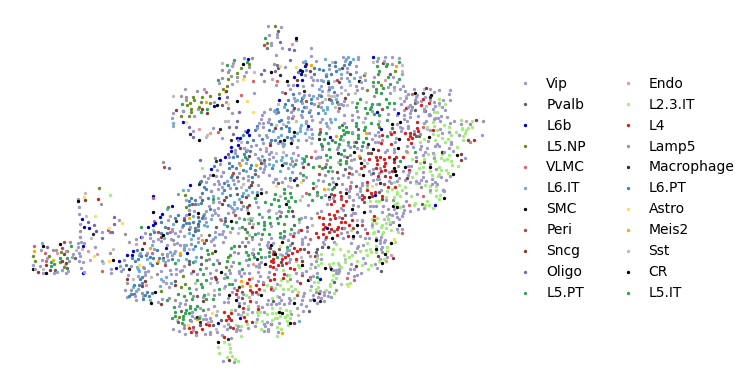

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
df = pd.read_csv( Test_dir +'/st_meta.csv',sep = ',',index_col=0)
cluster = df['celltype'].values
dt.plot_cell_type_ST(ad_st,mapping_colors,cluster)

**Spatial cell-cell communication at single-cell resolution**

Show Top 50 communication score for predticted cell-cell communication

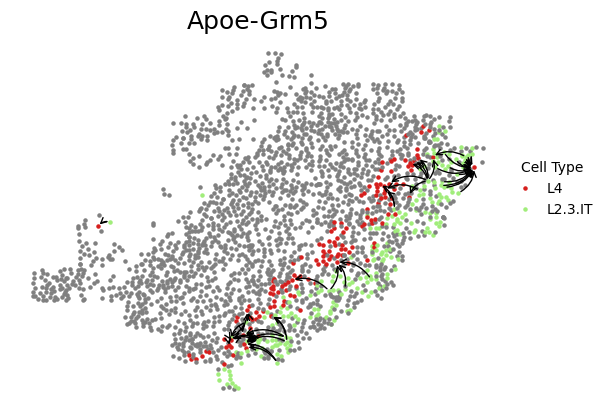

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_ST(ad_st, mapping_colors, cluster, data_name = Test_dir + '/ad_st_new.csv',ligand = 'Apoe',
    receptor = 'Grm5',CCC_label = Test_dir + '/data/Apoe_Grm5/predict_ccc.txt',
    sourcetype = 'L2.3.IT',targettype = 'L4',top_score = 50)

**Cell-cell communication between cell types**

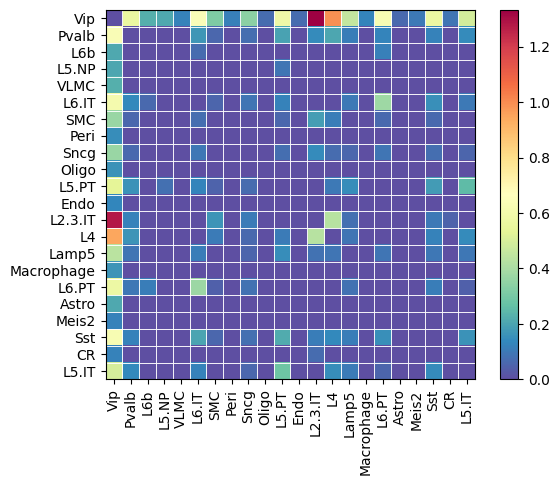

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_heatmap(cluster, data_name = Test_dir + '/ad_st_new.csv',
    ligand = 'Apoe', receptor = 'Grm5',
    CCC_label = Test_dir + '/data/Apoe_Grm5/predict_ccc.txt')